# Make figures

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import glob
import sys
from shapely import wkt
import seaborn as sns
import string
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
import ast

In [2]:
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/'
sys.path.append(os.path.join(base_path, 'functions'))
import model_analyze_utils as f

scm_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
figures_out_path = os.path.join(base_path, 'figures')
aois_path = os.path.join(scm_path, 'all_AOIs')
aois_fn = 'all_aois.shp'
eras_path = os.path.join(scm_path, 'all_ERA_data')
eras_fn = 'all_era_data.csv'
snowlines_path = os.path.join(scm_path, 'all_snowlines')
snowlines_fn = 'all_snowlines.csv'
snowlines_medians_fn = 'all_snowlines_weekly_median_trends.csv'

## Plot minimum AAR with different characteristics

In [3]:
# -----Load minimum snow cover characteristics
min_snow_cover_stats_fn = 'min_snow_cover_stats.csv'
min_snow_cover_stats = pd.read_csv(os.path.join(snowlines_path, min_snow_cover_stats_fn))
min_snow_cover_stats['geometry'] = min_snow_cover_stats['geometry'].apply(wkt.loads)
# sort by region numbers
min_snow_cover_stats.sort_values(by=['O1Region', 'O2Region'], inplace=True)

# -----Add glacier boundary x and y centroid coordinates for plotting
min_snow_cover_stats['centroid_x'] = [x.centroid.coords.xy[0][0] for x in min_snow_cover_stats['geometry']]
min_snow_cover_stats['centroid_y'] = [x.centroid.coords.xy[1][0] for x in min_snow_cover_stats['geometry']]

# -----Load country outlines for plotting
countries_fn = os.path.join(scm_path, '..', 'GIS_data', 'countries_shp', 'countries.shp')
countries = gpd.read_file(countries_fn)
usca = countries.loc[(countries['NAME']=='United States') | (countries['NAME']=='Canada')].reset_index(drop=True)

/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

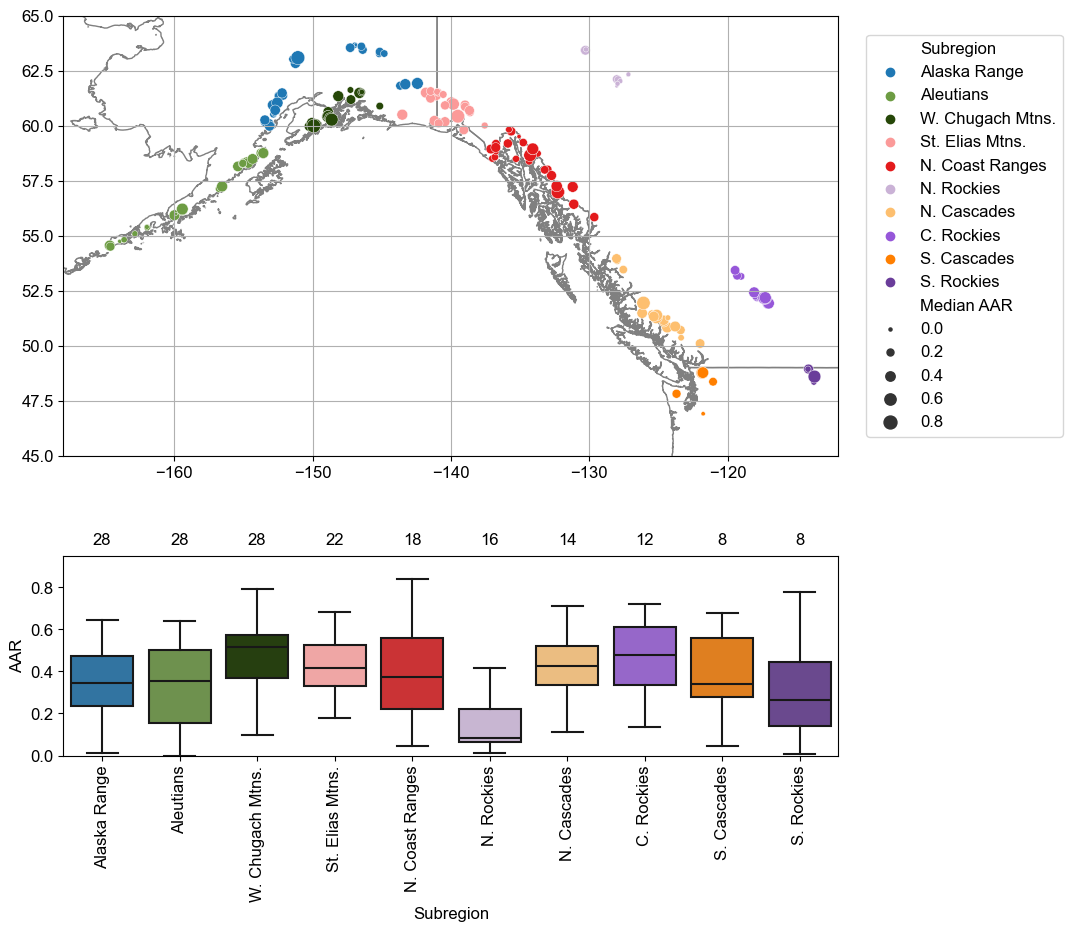

figure saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/AARs_map_Subregion.png


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

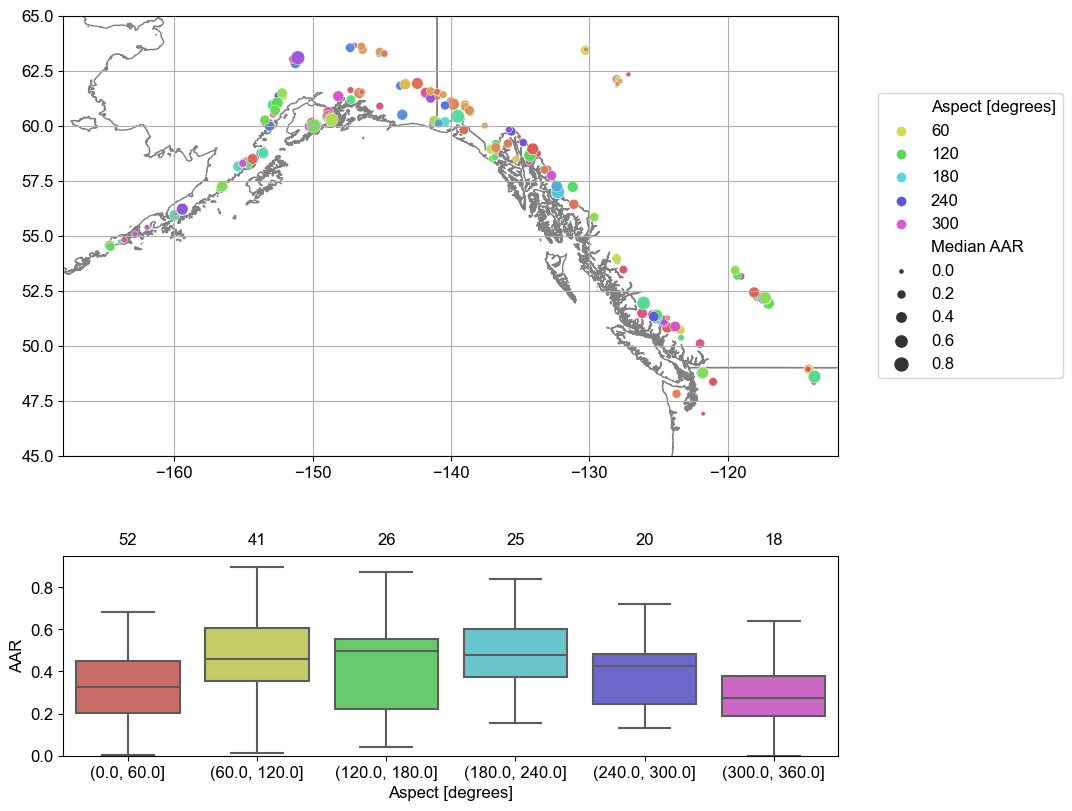

figure saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/AARs_map_Aspect.png


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

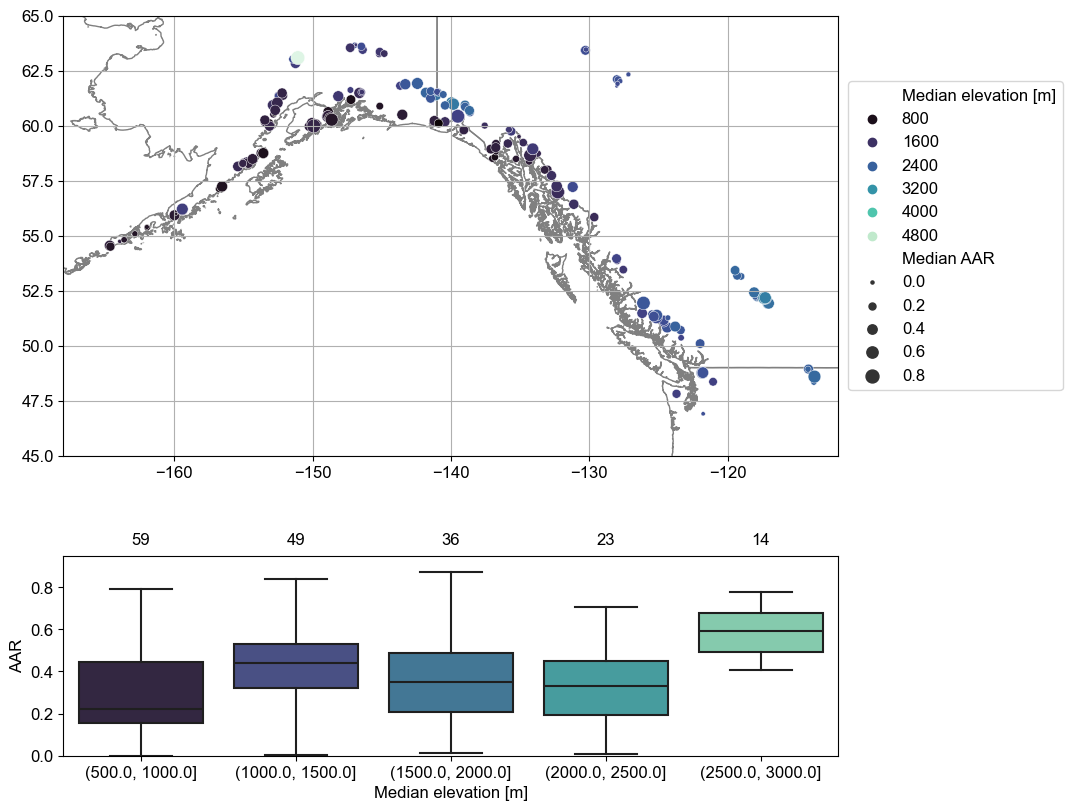

figure saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/AARs_map_Zmed.png


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

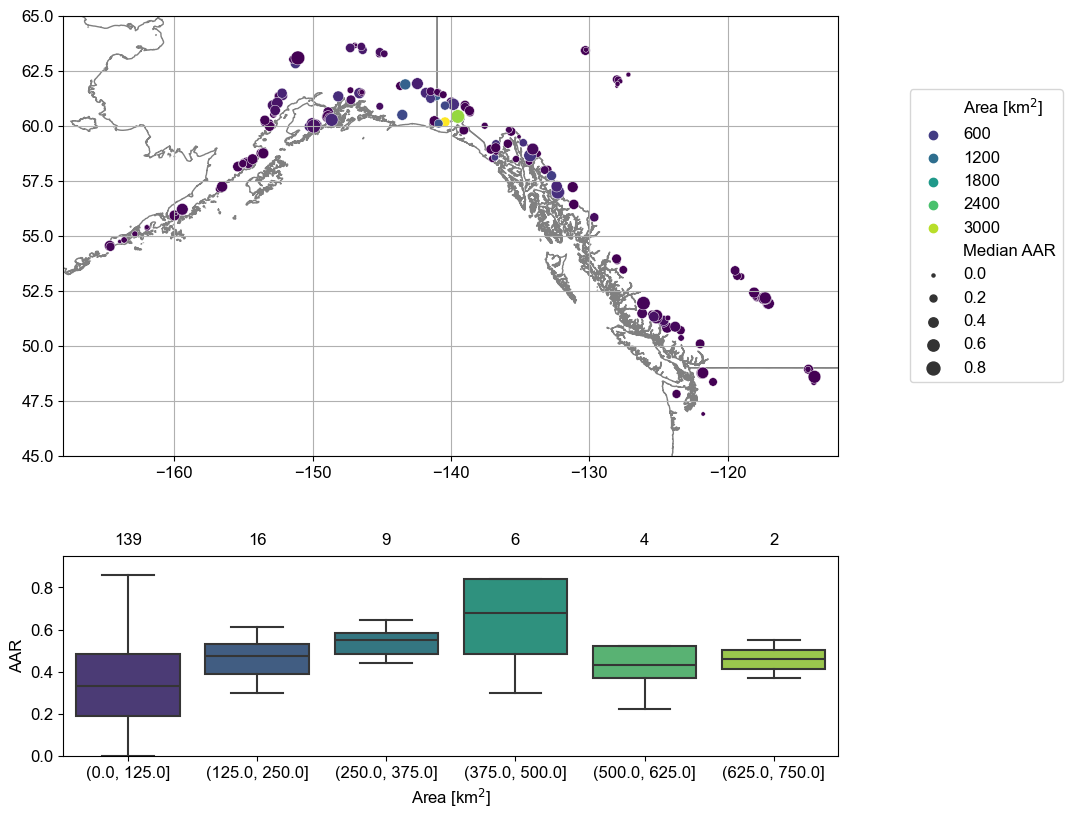

figure saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/AARs_map_Area.png


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/seaborn/_oldc

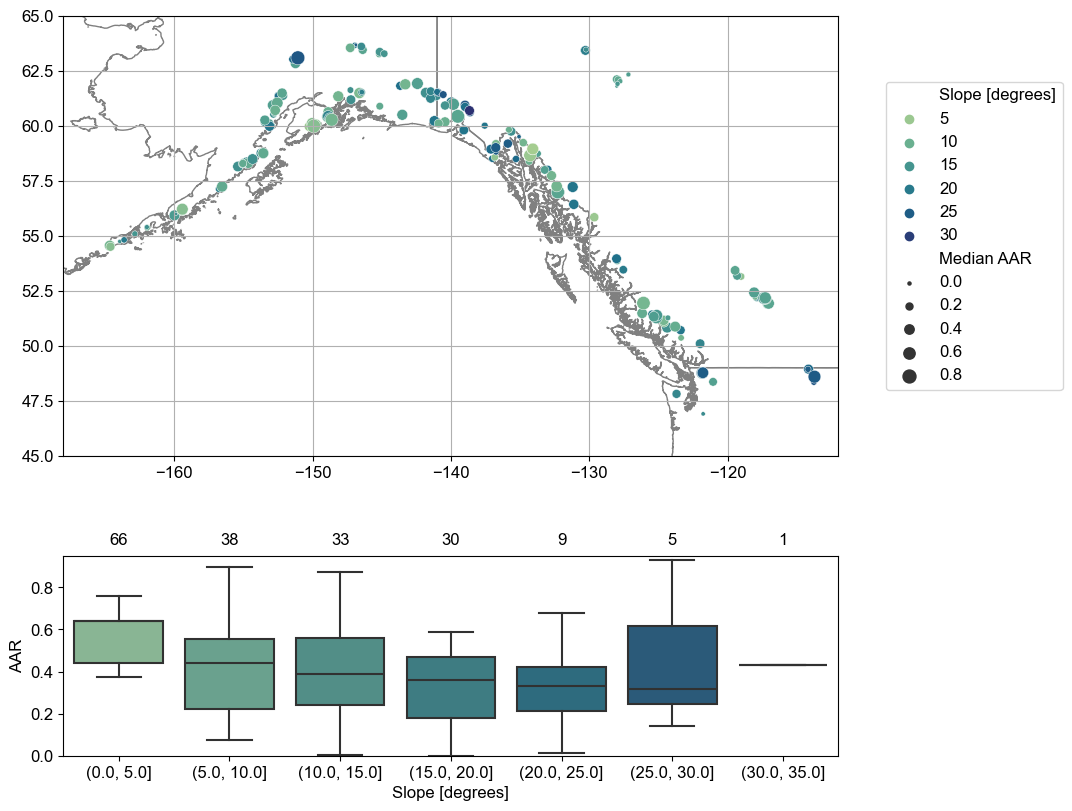

figure saved to file:  /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping-application/figures/AARs_map_Slope.png


In [58]:
# -----Plot maps of minimum AARs by various columns
columns = ['Subregion', 'Aspect', 'Zmed', 'Area', 'Slope']
columns_display = ['Subregion', 'Aspect [degrees]', 'Median elevation [m]', 'Area [km$^2$]', 'Slope [degrees]']
palettes = [dict(min_snow_cover_stats[['Subregion', 'color']].drop_duplicates().values),
            'hls', 
            'mako', 
            'viridis', 
            'crest']
bins_list = ['N/A', 
             np.linspace(0,360, num=7), 
             np.linspace(500, 3000, num=6),
             np.linspace(0, 750, num=7),
             np.linspace(0, 35, num=8)]
plt.rcParams.update({'font.sans-serif':'Arial', 'font.size':12})
xmin, xmax = -168, -112
ymin, ymax = 45, 65
for column, column_display, palette, bins in zip(columns, columns_display, palettes, bins_list):
    fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios':[2.5, 1]})
    # plot country outlines on the map
    usca.plot(ax=ax[0], facecolor='None', edgecolor='grey')
    if column !='Subregion':
        # # Create a custom colormap with specified colormap limits
        # cmap = plt.cm.viridis  # Choose your desired colormap
        # norm = Normalize(vmin=np.min(bins), vmax=np.max(bins))
        # custom_cmap = sns.color_palette([cmap(norm(value)) for value in bins], as_cmap=True)
        # plot points on the map
        sns.scatterplot(data=min_snow_cover_stats, x='centroid_x', y='centroid_y', 
                        hue=column, size='AAR_P50_min', palette=palette,
                        sizes=(5, 100), legend=True, ax=ax[0])
        # add bin column
        min_snow_cover_stats[column + '_bin'] = pd.cut(min_snow_cover_stats[column], bins)
        # plot boxplots
        sns.boxplot(data=min_snow_cover_stats, x=column + '_bin', y='AAR_P50_min', showfliers=False, palette=palette, ax=ax[1])
        # calculate number of observations in each bin
        nobs = min_snow_cover_stats[column + '_bin'].value_counts().values
    else:
        # plot points on the map
        scatter = sns.scatterplot(data=min_snow_cover_stats, x='centroid_x', y='centroid_y', 
                                  hue=column, palette=palette, size='AAR_P50_min', 
                                  sizes=(5, 100), legend=True, ax=ax[0])
        # plot boxplots
        sns.boxplot(data=min_snow_cover_stats, x=column, y='AAR_P50_min', showfliers=False, palette=palette, ax=ax[1])
        ax[1].set_xticks(ax[1].get_xticks())
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
        # calculate number of obserations in each bin
        nobs = min_snow_cover_stats['Subregion'].value_counts().values
    # Add number of observations to the boxplot
    nobs = [str(x) for x in nobs.tolist()]
    pos = range(len(nobs))
    for tick in pos:
        ax[1].text(pos[tick], 1.0,
                   nobs[tick],
                   horizontalalignment='center',
                   color='k')
    # adjust legend and axes
    sns.move_legend(ax[0], "center right", bbox_to_anchor=[1.1, 0.4, 0.2, 0.2])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].grid()
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_xlabel(column_display)
    ax[1].set_ylim(0, 0.95)
    ax[1].set_ylabel('AAR')

    # Edit legend labels for map
    handles, labels = ax[0].get_legend_handles_labels()
    labels = [x.replace('AAR_P50_min', 'Median AAR').replace(column, column_display) for x in labels]
    ax[0].legend(handles, labels, loc='center right')
    sns.move_legend(ax[0], "center right", bbox_to_anchor=[1.1, 0.4, 0.2, 0.2])
    
    plt.show()
    
    # Save figure
    fig_fn = 'AARs_map_' + column + '.png'
    fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=250, bbox_inches='tight')
    print('figure saved to file: ', os.path.join(figures_out_path, fig_fn))

## Plot linear changes in AARs for 2016-2023 by terrain characteristics

In [ ]:
# -----Load AARs linear fit
aars_linear_fit_fn = 'minimum_AARs_linear_fit.csv'
aars_linear_fit = pd.read_csv(os.path.join(snowlines_path, aars_linear_fit_fn))

# -----Add glacier terrain and geometry columns
columns = ['geometry', 'centroid_x', 'centroid_y', 'O1Region', 'O2Region', 'Subregion', 'color', 'Aspect', 'Slope', 'Zmed', 'Area']
for column in columns:
    aars_linear_fit[column] = np.nan
# iterate over site names
for site_name in aars_linear_fit['site_name'].drop_duplicates().values:
    min_snow_cover_stats_site = min_snow_cover_stats.loc[min_snow_cover_stats['RGIId']==site_name]
    try:
        for column in columns:
            aars_linear_fit.loc[aars_linear_fit['site_name']==site_name, column] = [min_snow_cover_stats_site[column].values[0]]
    except:
        continue

aars_linear_fit.dropna(inplace=True)

# -----Add column for negative value of change category to show more negative values as larger markers
aars_linear_fit['linear_fit_coef_neg'] = - aars_linear_fit['linear_fit_coef']
# Sort by region numbers
aars_linear_fit.sort_values(by=['O1Region', 'O2Region'], inplace=True)
aars_linear_fit

In [ ]:
# -----Plot map of AARs linear fit with various columns
columns = ['Subregion', 'Aspect', 'Zmed', 'Area', 'Slope']
columns_display = ['Subregion', 'Aspect [degrees]', 'Median elevation [m]', 'Area [km$^2$]', 'Slope [degrees]']
palettes = [dict(aars_linear_fit[['Subregion', 'color']].drop_duplicates().values),
            'hls', 
            'mako', 
            'viridis', 
            'crest']
bins_list = ['N/A', 
             np.linspace(0,360, num=7), 
             np.linspace(500, 3000, num=6),
             np.linspace(0, 750, num=7),
             np.linspace(0, 35, num=8)]
plt.rcParams.update({'font.sans-serif':'Arial', 'font.size':12})
xmin, xmax = -168, -112
ymin, ymax = 45, 65
def map_size(value):
    return np.abs(value) * 100
for column, column_display, palette, bins in zip(columns, columns_display, palettes, bins_list):
    fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'height_ratios':[2.5, 1]})
    # plot country outlines on the map
    usca.plot(ax=ax[0], facecolor='None', edgecolor='grey')
    # plot points on the map
    if type(bins) != str:
        sns.scatterplot(data=aars_linear_fit, x='centroid_x', y='centroid_y', 
                        hue=column, palette=palette, size='linear_fit_coef_neg', sizes=(5, 150), legend=True, ax=ax[0])
    else:
        sns.scatterplot(data=aars_linear_fit, x='centroid_x', y='centroid_y', 
                        hue=column, palette=palette, size='linear_fit_coef_neg', sizes=(5, 150), legend=True, ax=ax[0])
    ax[0].set_xlabel('')
    ax[0].set_ylabel('')
    ax[0].grid()
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    # plot regional barplots
    if type(bins) != str:
        # add bin column
        aars_linear_fit[column + '_bin'] = pd.cut(aars_linear_fit[column], bins)
        # plot boxplots
        sns.boxplot(data=aars_linear_fit, x=column + '_bin', y='linear_fit_coef', showfliers=False, palette=palette, ax=ax[1])
    else:
        # plot boxplots
        sns.boxplot(data=aars_linear_fit, x=column, y='linear_fit_coef', showfliers=False, palette=palette, ax=ax[1])
    if type(bins) == str:
        ax[1].set_xticks(ax[1].get_xticks())
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_xlabel(column_display)
    ax[1].set_ylabel('AAR linear trend [per year]')
    
    # Edit legend labels for map
    handles, labels = ax[0].get_legend_handles_labels()
    labels = [x.replace('linear_fit_coef_neg', 'AAR linear trend [per year]').replace(column, column_display) for x in labels]
    labels = [x.replace('0.', '-0.').replace('−-0', '0') for x in labels]
    ax[0].legend(handles, labels, loc='center right')
    sns.move_legend(ax[0], "center right", bbox_to_anchor=[1.15, 0.4, 0.2, 0.2])

    plt.show()

    # Save figure
    fig_fn = 'AARs_linear_fit_map_' + column + '.png'
    fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=250, bbox_inches='tight')
    print('figure saved to file: ', os.path.join(figures_out_path, fig_fn))

## Plot AAR and linear fit time series for each site

In [ ]:
# Load snowlines
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
# Load minimum AAR fits
min_aars_fn = 'minimum_AARs_linear_fit.csv'
min_aars = pd.read_csv(os.path.join(snowlines_path, min_aars_fn))


In [ ]:
# Iterate over sites
for site_name in tqdm(min_aars['site_name'].drop_duplicates().values):
    # Grab snowlines
    snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
    # Grab min AARs
    min_aars_site = min_aars.loc[min_aars['site_name']==site_name].reset_index(drop=True)
    # Plot
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(snowlines_site['datetime'], snowlines_site['AAR'], '.k', markersize=1)
    ax.plot(min_aars_site['minimum_AARs_dts'], min_aars_site['minimum_AARs'], '*m', markersize=2)
    ax.grid()
    ax.set_title(site_name)
    plt.show()

In [ ]:
ast.literal_eval(min_aars['minimum_AARs'][0])#.apply(ast.literal_eval)

## Plot AAR and PDD time series

In [ ]:
# -----Load all snowlines
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')

# -----Load all ERA data
eras = pd.read_csv(os.path.join(eras_path, eras_fn))
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')

# -----Load all AOIs
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)

In [ ]:
# -----Plot median trends for each subregion
# add year and WOY columns to snowlines and ERA
snowlines['Year'] = snowlines['datetime'].dt.isocalendar().year
snowlines['WOY'] = snowlines['datetime'].dt.isocalendar().week
eras['Year'] = eras['Date'].dt.isocalendar().year
eras['WOY'] = eras['Date'].dt.isocalendar().week
# grab all subregions
subregions = aois[['O1Region', 'O2Region']].drop_duplicates().values
# Set up figure
fig, ax = plt.subplots(len(subregions), 1, figsize=(10, 4*len(subregions)))
text_labels = [x for x in string.ascii_lowercase[0:len(subregions)]]
# Iterate over subregions
for i, (o1region, o2region) in enumerate(subregions):
    
    subregion_name, color = f.determine_subregion_name_color(o1region, o2region)
    
    # Grab all AOIs in subregion
    aois_subregion = aois.loc[(aois['O1Region']==o1region) & (aois['O2Region']==o2region)]
    site_names_subregion = aois_subregion['RGIId'].drop_duplicates().values
    # Grab all snowlines in subregion
    Isubregion = [i for i in np.arange(len(snowlines)) 
                  if snowlines.loc[i, 'site_name'] in site_names_subregion]
    snowlines_subregion = snowlines.iloc[Isubregion]
    # Calculate AAR median and IQR trends over time
    aar_median = snowlines_subregion.groupby(by=['Year', 'WOY'])['AAR'].median().reset_index()
    aar_median['deciyear'] = aar_median['Year'] + (aar_median['WOY'] / 52)
    # aar_q1 = snowlines_subregion.groupby(by=['Year', 'WOY'])['AAR'].apply(np.quantile(q=0.25))
    # aar_q3 = snowlines_subregion.groupby(by=['Year', 'WOY'])['AAR'].apply(np.quantile(q=0.75))
    # Grab all ERA data in subregion
    Isubregion = [i for i in np.arange(len(eras)) 
                  if eras.loc[i, 'site_name'] in site_names_subregion]
    eras_subregion = eras.iloc[Isubregion]
    # Calculate PDD median and IQR trends over time
    pdd_median = eras_subregion.groupby(by=['Year', 'WOY'])['Cumulative_Positive_Degree_Days'].median().reset_index()
    pdd_median['deciyear'] = pdd_median['Year'] + (pdd_median['WOY'] / 52)
    # pdd_q1 = eras_subregion.groupby(by=['Year', 'WOY'])['Cumulative_Positive_Degree_Days'].apply(np.quantile(q=0.25))
    # pdd_q3 = eras_subregion.groupby(by=['Year', 'WOY'])['Cumulative_Positive_Degree_Days'].apply(np.quantile(q=0.75))

    # Plot
    ax[i].plot(aar_median['deciyear'], aar_median['AAR'], '.-b', linewidth=0.5, markersize=3)
    ax[i].grid()
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel('Transient AAR', color='b')
    ax[i].tick_params(axis='y', colors='b')
    ax[i].set_title(text_labels[i] + ') ' + subregion_name)
    ax2 = ax[i].twinx()
    ax2.plot(pdd_median['deciyear'], pdd_median['Cumulative_Positive_Degree_Days'], '-m')
    ax2.set_ylabel('$\Sigma$PDD', color='m')
    ax2.tick_params(axis='y', colors='m')
    
plt.show()

# -----Save figure
fig_fn = 'time_series_AAR_PDDs.png'
fig.savefig(os.path.join(figures_out_path, fig_fn), dpi=200, bbox_inches='tight')
print('figure saved to file:', os.path.join(figures_out_path, fig_fn))


## Plot correlation statistics

### AAR-PDD correlations

In [ ]:
# -----Load AAR-PDD correlations for each subregion
corr_coeffs_fns = sorted(glob.glob(os.path.join(eras_path, 'correlation_*aar-pdd*.csv')))
corr_coeffs = pd.DataFrame()
for corr_coeffs_fn in corr_coeffs_fns:
    # grab subregion name from file name
    subregion_name = os.path.basename(corr_coeffs_fn).split('aar-pdd_')[1].split('.csv')[0]
    # load correlation coefficients for all sites
    corr_coeffs_subregion = pd.read_csv(corr_coeffs_fn)
    # add subregion name to dataframe
    corr_coeffs_subregion['Subregion'] = subregion_name    
    # concatenate to full dataframe
    corr_coeffs = pd.concat([corr_coeffs, corr_coeffs_subregion])
corr_coeffs

In [ ]:
# -----Plot boxplots
palette = dict(min_snow_cover_stats[['Subregion', 'color']].drop_duplicates().values)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=corr_coeffs, x='Subregion', y='AAR-PDD Corr. Coeff.', palette=palette, ax=ax)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('AAR - $\Sigma$PDD Correlation Coefficients')
# ax.grid()
plt.show()

# -----Save to file
fig_fn = os.path.join(figures_out_path, 'aar-pdd_correlation_coefficients_boxplot.png')
fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
print('figure saved to file: ', fig_fn)

## Plot scatter plots of AAR vs. cumulative PDDs

In [ ]:
# -----Load all snowlines
snowlines = pd.read_csv(os.path.join(snowlines_path, snowlines_fn))
snowlines['datetime'] = pd.to_datetime(snowlines['datetime'], format='mixed')
snowlines['Date'] = snowlines['datetime'].values.astype('datetime64[D]')

# -----Load all ERA data
eras = pd.read_csv(os.path.join(eras_path, eras_fn))
eras['Date'] = pd.to_datetime(eras['Date'], format='mixed')

# -----Load all AOIs
aois = gpd.read_file(os.path.join(aois_path, aois_fn))
aois[['O1Region', 'O2Region']] = aois[['O1Region', 'O2Region']].astype(int)

In [ ]:
# -----Fit multiple linear regression model to AAR, PDDs, and Snowfall
# intialize full dataframe
snowlines_eras_merged = pd.DataFrame()
# iterate over sites
for site_name in tqdm(snowlines['site_name'].drop_duplicates().values):
    # subset dataframes to site
    snowlines_site = snowlines.loc[snowlines['site_name']==site_name]
    eras_site = eras.loc[eras['site_name']==site_name]
    # merge snowlines and ERA dataframes
    snowlines_eras_merged_site = snowlines_site.merge(eras_site, how='left', on='Date')
    snowlines_eras_merged_site.rename(columns={'site_name_x': 'site_name'}, inplace=True)
    # save in dataframe
    snowlines_eras_merged_site = snowlines_eras_merged_site[['site_name', 
                                                             'AAR', 
                                                             'Cumulative_Positive_Degree_Days',
                                                             'Cumulative_Precipitation_mwe',
                                                             'Cumulative_Snowfall_mwe']]
    snowlines_eras_merged_site.reset_index(drop=True, inplace=True)
    snowlines_eras_merged_site.dropna()
    # plot
    ax.plot(snowlines_eras_merged_site['Cumulative_Positive_Degree_Days'], 
            snowlines_eras_merged_site['AAR'], 
            '.', markersize=1)
    # concatenate to full dataframe
    snowlines_eras_merged = pd.concat([snowlines_eras_merged, snowlines_eras_merged_site])
    

In [ ]:
# -----Fit multi-linear regression model
snowlines_eras_merged.dropna(inplace=True)
model = LinearRegression()
X_columns = ['Cumulative_Positive_Degree_Days', 'Cumulative_Snowfall_mwe']
# fit model
X = snowlines_eras_merged[X_columns]
y = snowlines_eras_merged['AAR'].values
model_fit = model.fit(X, y)
# calculate R^2
r2 = model_fit.score(X, y)
# plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot(X[X_columns[0]], X[X_columns[1]], y, '.', color='grey', markersize=0.5)
y_pred = model_fit.predict(X)
ax.plot(X[X_columns[0]], X[X_columns[1]], y_pred, '.k')
ax.set_xlabel(X_columns[0])
ax.set_ylabel(X_columns[1])
ax.set_zlabel('AAR')
ax.set_title('AAR = ' + str(np.round(model_fit.coef_[0], 5)) + '*$\Sigma$PDDs ' 
             + str(np.round(model_fit.coef_[1], 5)) + '*$\Sigma$Snowfall' 
             + '\nR$^2$ = ' + str(np.round(r2,55)))
plt.show()

# Save figure
fig_fn = os.path.join(figures_out_path, 'aar-pdd-snowfall_multiple_linear_regression.png')
fig.savefig(fig_fn, dpi=200, bbox_inches='tight')
print('figure saved to file:', fig_fn)